In [1]:
import pandas as pd
import tarfile
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import re
import wordcloud
import nltk
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor


In [2]:
import sys
sys.path.append('src')

from data.dataloader import load_beer_advocate_data

# Load the BeerAdvocate data
beers_ba, reviews_ba, users_ba, breweries_ba, ratings_ba = load_beer_advocate_data()

import sys
sys.path.append('src')

from src.scripts.script import format_data

In [3]:
reviews_ba = format_data(reviews_ba, "review_id")
# Merge the reviews with user information on location
reviews_ba = reviews_ba.merge(users_ba[['user_id', 'location']], on='user_id', how='left')
# Remove the states to only have the countries
reviews_ba['country'] = reviews_ba['location'].str.split(',').str[0]
# Remove the countries to only have the states
reviews_ba['states'] = reviews_ba['location'].str.split(',').str[1]
# We only keep users from the US
reviews = reviews_ba[reviews_ba['country'] == 'United States']

In [4]:
# Reshape the ratings dataset
ratings_ba = format_data(ratings_ba, "rating_id")
# Merge the reviews with user information on location
ratings_ba = ratings_ba.merge(users_ba[['user_id', 'location']], on='user_id', how='left')
# Remove the states to only have the countries
ratings_ba['country'] = ratings_ba['location'].str.split(',').str[0]
# Remove the countries to only have the states
ratings_ba['states'] = ratings_ba['location'].str.split(',').str[1]
# We only keep users from the US
ratings = ratings_ba[ratings_ba['country'] == 'United States']

In [5]:
# Separate the country and the states
users_ba['country'] = users_ba['location'].str.split(',').str[0]
users_ba['states'] = users_ba['location'].str.split(',').str[1]
# Keep only users from the US
users = users_ba[users_ba['country'] == 'United States']

In [6]:
reviews.to_csv('data/reviews_processed.csv.gz', index=False, compression='gzip')
ratings.to_csv('data/ratings_processed.csv.gz', index=False, compression='gzip')
users.to_csv('data/users_processed.csv.gz', index=False, compression='gzip')
beers_ba.to_csv('data/beers_ba_processed.csv.gz', index=False, compression='gzip')
breweries_ba.to_csv('data/breweries_ba_processed.csv.gz', index=False, compression='gzip')

**Load the data from local**

In [7]:
reviews = pd.read_csv('data/reviews_processed.csv.gz', compression='gzip')
ratings = pd.read_csv('data/ratings_processed.csv.gz', compression='gzip')
users = pd.read_csv('data/users_processed.csv.gz', compression='gzip')
beers_ba = pd.read_csv('data/beers_ba_processed.csv.gz', compression='gzip')
breweries_ba = pd.read_csv('data/breweries_ba_processed.csv.gz', compression='gzip')

In [8]:
def preprocess_text(text):
    words = re.findall(r'\b\w+\b', text.lower())  
    return words

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/cleo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Most used words in reviews

/var/folders/kn/xrv1vh8j0k99dnh2mwl662xc0000gn/T/ipykernel_25020/881537091.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_clean['cleaned_tokens'] = reviews_clean['text'].apply(preprocess_text)
Processing Reviews: 100%|██████████| 2241332/2241332 [01:03<00:00, 35389.71it/s]


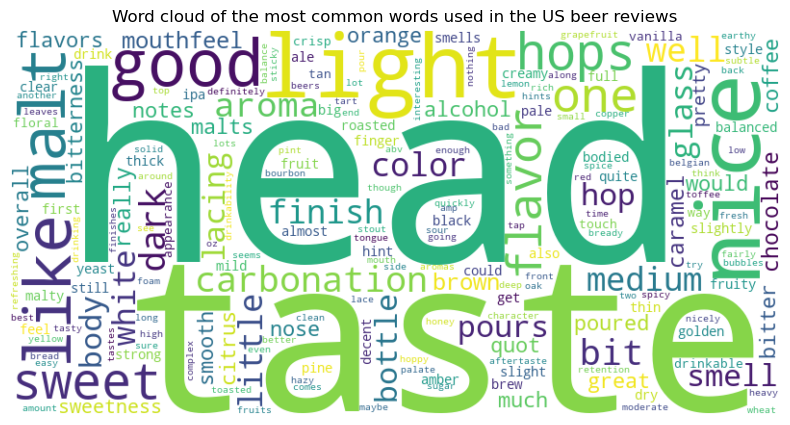

In [10]:
# We analyze the words that are used in the reviews

# Remove rows where 'text' is NaN or not a string
reviews_clean = reviews[reviews['text'].apply(lambda x: isinstance(x, str))]
# Now apply the preprocess_text function
reviews_clean['cleaned_tokens'] = reviews_clean['text'].apply(preprocess_text)

# Flatten the list of words from all reviews, filtering out non-alphabetic and stop words directly
stop_words = set(stopwords.words('english'))
all_words = (
    word
    for tokens in tqdm(reviews_clean['cleaned_tokens'], desc="Processing Reviews")
    for word in tokens
    if word.isalpha() and word not in stop_words and word.lower() != "beer"
)

# Count word frequencies directly
word_freq = Counter(all_words)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud of the most common words used in the US beer reviews')
plt.show()

### Most used pairs of words in reviews

In [11]:
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import nltk
nltk.download('stopwords')  # Ensure stop words are downloaded

# Define stop words
stop_words = set(stopwords.words('english'))

# Analyze the pair of words (bigrams) used in the reviews
# Flatten the list of bigrams from all reviews, filtering out stop words and non-alphabetic tokens directly
all_bigrams = (
    bigram
    for tokens in tqdm(reviews_clean['cleaned_tokens'], desc="Processing Reviews for Bigrams")
    for bigram in zip(tokens[:-1], tokens[1:])  # Create bigrams
    if all(
        word.isalpha() and word.lower() not in stop_words and word.lower() != "beer"
        for word in bigram
    )  # Filter out stop words and specific unwanted words
)

# Count bigram frequencies
bigram_freq = Counter(all_bigrams)

# Convert bigrams (tuples) to strings for the word cloud
bigram_freq_str = {" ".join(bigram): freq for bigram, freq in bigram_freq.items()}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_freq_str)

[nltk_data] Downloading package stopwords to /Users/cleo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Processing Reviews for Bigrams: 100%|██████████| 2241332/2241332 [05:06<00:00, 7319.39it/s] 


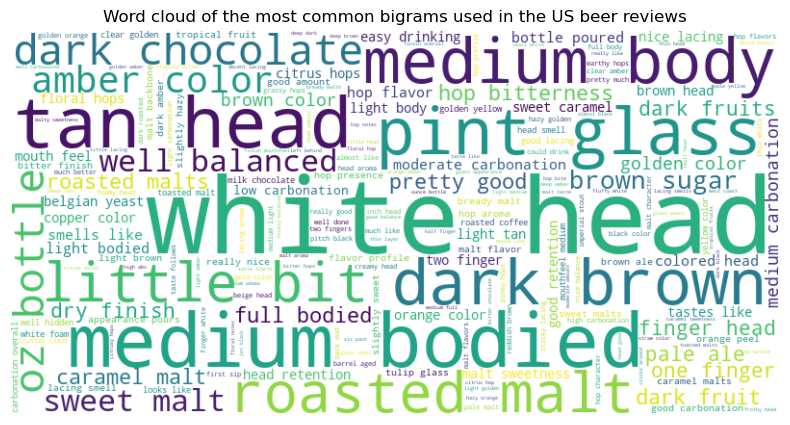

In [12]:
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud of the most common bigrams used in the US beer reviews')
plt.show()

### Palate analysis

In [13]:
# Define stop words
stop_words = set(stopwords.words('english'))

# Separate the reviews into two groups: those with a palate rating higher than 4 and those with a palate rating lower than 4
reviews_high = reviews_clean[reviews_clean['palate'] > 4]
reviews_low = reviews_clean[reviews_clean['palate'] < 3]

# Flatten the list of words from all reviews in each group, excluding stop words
all_words_high = [
    word
    for tokens in tqdm(reviews_high['cleaned_tokens'], desc="Processing High Palate Ratings")
    for word in tokens
    if word.isalpha() and word.lower() not in stop_words and word.lower() != "beer"
]

all_words_low = [
    word
    for tokens in tqdm(reviews_low['cleaned_tokens'], desc="Processing Low Palate Ratings")
    for word in tokens
    if word.isalpha() and word.lower() not in stop_words and word.lower() != "beer"
]

# Count word frequencies for each group
word_freq_high = Counter(all_words_high)
word_freq_low = Counter(all_words_low)

# Generate the word clouds
wordcloud_high = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_high)
wordcloud_low = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_low)

Processing Low Palate Ratings: 100%|██████████| 130476/130476 [00:16<00:00, 7952.69it/s] 


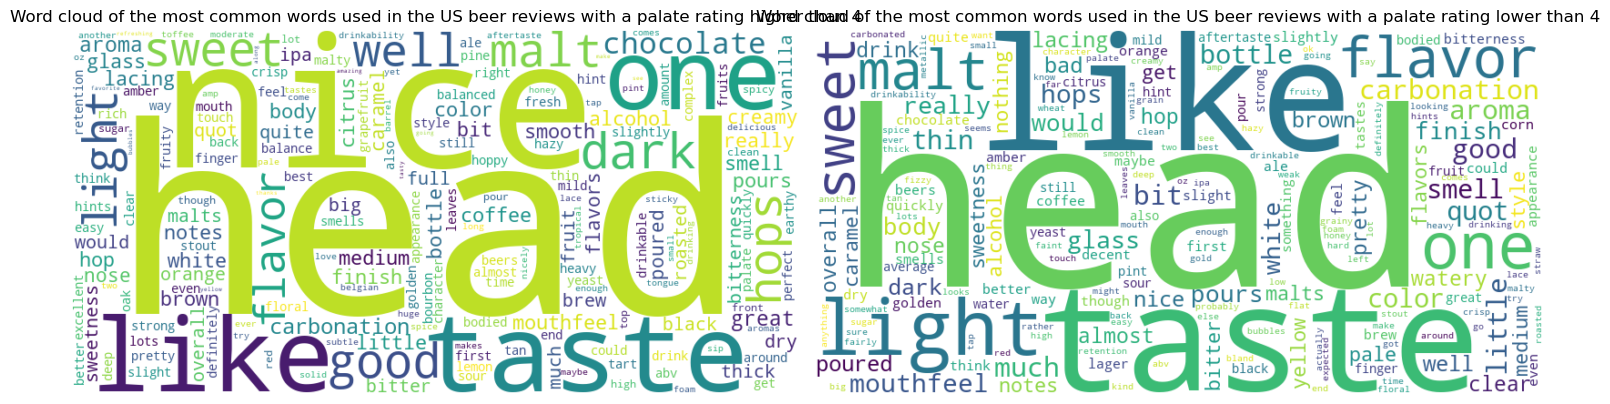

In [14]:
# Plot the word clouds
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_high, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud of the most common words used in the US beer reviews with a palate rating higher than 4')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_low, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud of the most common words used in the US beer reviews with a palate rating lower than 4')

plt.tight_layout()
plt.show()

### Same thing but for pairs of words

In [15]:
# Define stop words
stop_words = set(stopwords.words('english'))

# Separate the reviews into two groups: those with a palate rating higher than 4 and those with a palate rating lower than 3
reviews_high = reviews_clean[reviews_clean['palate'] > 4]
reviews_low = reviews_clean[reviews_clean['palate'] < 3]

# Generate bigrams for each group, excluding stop words and non-alphabetic tokens
bigrams_high = [
    " ".join(bigram)
    for tokens in tqdm(reviews_high['cleaned_tokens'], desc="Processing High Palate Ratings")
    for bigram in zip(tokens[:-1], tokens[1:])  # Create bigrams
    if all(
        word.isalpha() and word.lower() not in stop_words and word.lower() != "beer"
        for word in bigram
    )  # Filter out stop words and specific unwanted words
]

bigrams_low = [
    " ".join(bigram)
    for tokens in tqdm(reviews_low['cleaned_tokens'], desc="Processing Low Palate Ratings")
    for bigram in zip(tokens[:-1], tokens[1:])  # Create bigrams
    if all(
        word.isalpha() and word.lower() not in stop_words and word.lower() != "beer"
        for word in bigram
    )  # Filter out stop words and specific unwanted words
]

# Count bigram frequencies for each group
bigram_freq_high = Counter(bigrams_high)
bigram_freq_low = Counter(bigrams_low)

# Generate the word clouds
wordcloud_high = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_freq_high)
wordcloud_low = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_freq_low)


Processing Low Palate Ratings: 100%|██████████| 130476/130476 [00:12<00:00, 10670.91it/s]


In [16]:
# Get the top 20 most common bigrams in each group
top_bigrams_high = bigram_freq_high.most_common(20)
top_bigrams_low = bigram_freq_low.most_common(20)

# Function to calculate the percentage of reviews containing each bigram
def calculate_percentage_of_reviews_containing_bigram(bigrams, reviews):
    percentages = []
    for bigram, _ in bigrams:
        # Check how many reviews contain this bigram
        num_reviews_containing_bigram = sum(
            1 for tokens in reviews['cleaned_tokens'] if tuple(bigram.split()) in zip(tokens[:-1], tokens[1:])
        )
        percentage = (num_reviews_containing_bigram / len(reviews)) * 100 if len(reviews) > 0 else 0
        percentages.append((bigram, percentage))
    return percentages

# Calculate percentages for each group
percentages_high = calculate_percentage_of_reviews_containing_bigram(top_bigrams_high, reviews_high)
percentages_low = calculate_percentage_of_reviews_containing_bigram(top_bigrams_low, reviews_low)

# Create DataFrames for comparison
df_high = pd.DataFrame(percentages_high, columns=['Bigram', 'Percentage High Reviews'])
df_low = pd.DataFrame(percentages_low, columns=['Bigram', 'Percentage Low Reviews'])

# Merge the DataFrames
df_comparison = pd.merge(df_high, df_low, on='Bigram', how='outer')

# Sort by the most frequent bigrams in the high group
df_comparison = df_comparison.sort_values(by='Percentage High Reviews', ascending=False)

# Print or display the results
print(df_comparison)

            Bigram  Percentage High Reviews  Percentage Low Reviews
29      white head                18.834162               20.557804
26        tan head                 9.109177                4.874460
3       dark brown                 7.099012                4.972562
16   medium bodied                 6.990881                3.714859
9      full bodied                 6.203143                     NaN
4   dark chocolate                 5.681589                     NaN
17     medium body                 5.569132                     NaN
28   well balanced                 5.472354                     NaN
21      pint glass                 5.403871                7.508661
22    roasted malt                 4.552516                2.406573
5       dark fruit                 4.225418                     NaN
2      brown sugar                 3.874531                     NaN
18       oz bottle                 3.843894                4.106502
23   roasted malts                 3.778835     

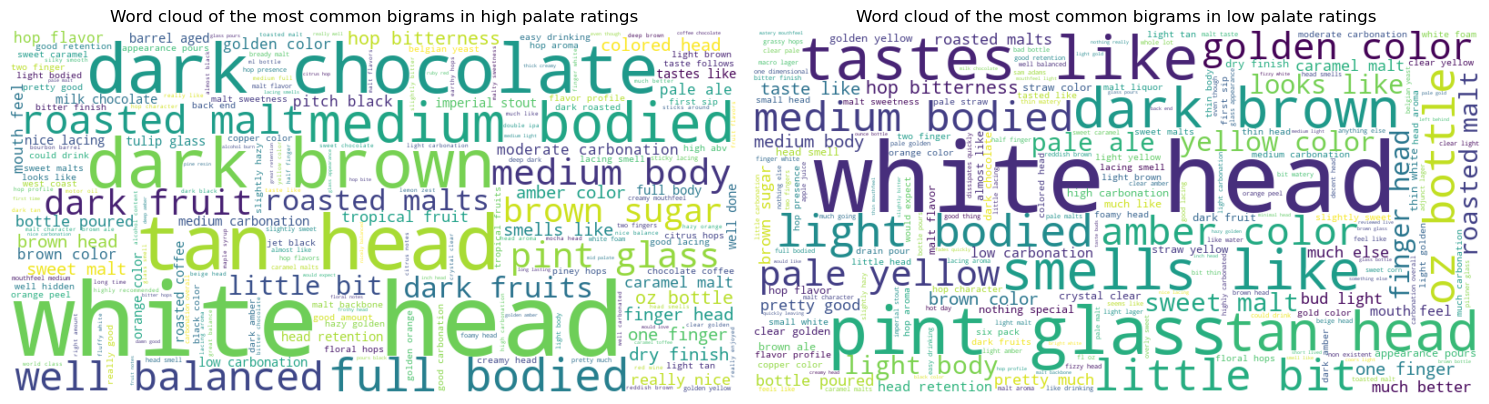

In [17]:
# Plot the word clouds
plt.figure(figsize=(15, 7))

# Word cloud for high palate ratings
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_high, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud of the most common bigrams in high palate ratings')

# Word cloud for low palate ratings
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_low, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud of the most common bigrams in low palate ratings')

plt.tight_layout()
plt.show()

### Appearance analysis

In [18]:
# Define stop words
stop_words = set(stopwords.words('english'))

# Separate the reviews into two groups: those with an appearance rating higher than 4 and those with an appearance rating lower than 4
reviews_high = reviews_clean[reviews_clean['appearance'] > 4]
reviews_low = reviews_clean[reviews_clean['appearance'] < 3]

# Flatten the list of words from all reviews in each group, excluding stop words
all_words_high = [
    word
    for tokens in tqdm(reviews_high['cleaned_tokens'], desc="Processing High Appearance Ratings")
    for word in tokens
    if word.isalpha() and word.lower() not in stop_words and word.lower() != "beer"
]

all_words_low = [
    word
    for tokens in tqdm(reviews_low['cleaned_tokens'], desc="Processing Low Appearance Ratings")
    for word in tokens
    if word.isalpha() and word.lower() not in stop_words and word.lower() != "beer"
]

# Count word frequencies for each group
word_freq_high = Counter(all_words_high)
word_freq_low = Counter(all_words_low)

# Generate the word clouds
wordcloud_high = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_high)
wordcloud_low = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_low)

Processing Low Appearance Ratings: 100%|██████████| 80445/80445 [00:06<00:00, 12534.30it/s]


In [19]:
# Get the top 20 most common bigrams in each group
top_bigrams_high = bigram_freq_high.most_common(20)
top_bigrams_low = bigram_freq_low.most_common(20)

# Function to calculate the percentage of reviews containing each bigram
def calculate_percentage_of_reviews_containing_bigram(bigrams, reviews):
    percentages = []
    for bigram, _ in bigrams:
        # Check how many reviews contain this bigram
        num_reviews_containing_bigram = sum(
            1 for tokens in reviews['cleaned_tokens'] if tuple(bigram.split()) in zip(tokens[:-1], tokens[1:])
        )
        percentage = (num_reviews_containing_bigram / len(reviews)) * 100 if len(reviews) > 0 else 0
        percentages.append((bigram, percentage))
    return percentages

# Calculate percentages for each group
percentages_high = calculate_percentage_of_reviews_containing_bigram(top_bigrams_high, reviews_high)
percentages_low = calculate_percentage_of_reviews_containing_bigram(top_bigrams_low, reviews_low)

# Create DataFrames for comparison
df_high = pd.DataFrame(percentages_high, columns=['Bigram', 'Percentage High Reviews'])
df_low = pd.DataFrame(percentages_low, columns=['Bigram', 'Percentage Low Reviews'])

# Merge the DataFrames
df_comparison = pd.merge(df_high, df_low, on='Bigram', how='outer')

# Sort by the most frequent bigrams in the high group
df_comparison = df_comparison.sort_values(by='Percentage High Reviews', ascending=False)

# Print or display the results
print(df_comparison)

            Bigram  Percentage High Reviews  Percentage Low Reviews
29      white head                19.057918               19.224315
26        tan head                 9.641565                2.094599
16   medium bodied                 8.162451                4.360743
3       dark brown                 7.044670                2.736031
17     medium body                 6.258414                     NaN
21      pint glass                 5.855516                7.738206
4   dark chocolate                 5.531608                     NaN
9      full bodied                 5.320472                     NaN
28   well balanced                 4.970234                     NaN
22    roasted malt                 4.824840                1.415874
23   roasted malts                 4.058953                     NaN
18       oz bottle                 4.017388                3.996519
11  hop bitterness                 3.979466                     NaN
1       brown head                 3.905278     

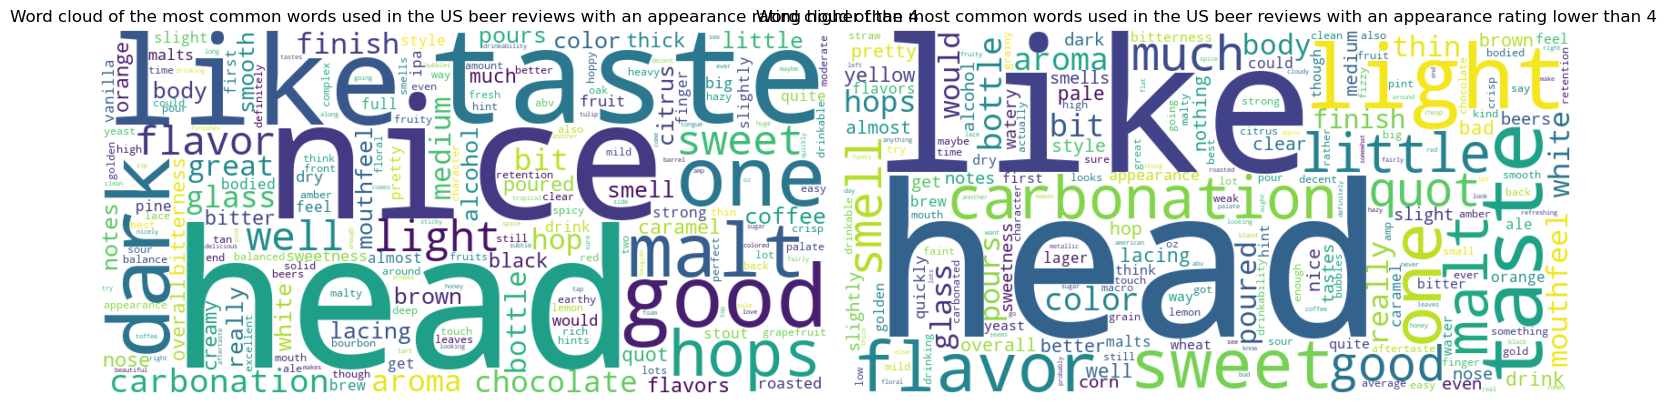

In [20]:
# Plot the word clouds
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_high, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud of the most common words used in the US beer reviews with an appearance rating higher than 4')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_low, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud of the most common words used in the US beer reviews with an appearance rating lower than 4')

plt.tight_layout()
plt.show()

### Same thing but for pairs of words

In [21]:
# Define stop words
stop_words = set(stopwords.words('english'))

# Separate the reviews into two groups: those with an appearance rating higher than 4 and those with an appearance rating lower than 3
reviews_high = reviews_clean[reviews_clean['appearance'] > 4]
reviews_low = reviews_clean[reviews_clean['appearance'] < 3]

# Generate bigrams for each group, excluding stop words and non-alphabetic tokens
bigrams_high = [
    " ".join(bigram)
    for tokens in tqdm(reviews_high['cleaned_tokens'], desc="Processing High Appearance Ratings")
    for bigram in zip(tokens[:-1], tokens[1:])  # Create bigrams
    if all(
        word.isalpha() and word.lower() not in stop_words and word.lower() != "beer"
        for word in bigram
    )  # Filter out stop words and specific unwanted words
]

bigrams_low = [
    " ".join(bigram)
    for tokens in tqdm(reviews_low['cleaned_tokens'], desc="Processing Low Appearance Ratings")
    for bigram in zip(tokens[:-1], tokens[1:])  # Create bigrams
    if all(
        word.isalpha() and word.lower() not in stop_words and word.lower() != "beer"
        for word in bigram
    )  # Filter out stop words and specific unwanted words
]

# Count bigram frequencies for each group
bigram_freq_high = Counter(bigrams_high)
bigram_freq_low = Counter(bigrams_low)

Processing Low Appearance Ratings: 100%|██████████| 80445/80445 [00:07<00:00, 11078.92it/s]


In [22]:
# Get the top 20 most common bigrams in each group
top_bigrams_high = bigram_freq_high.most_common(20)
top_bigrams_low = bigram_freq_low.most_common(20)

# Function to calculate the percentage of reviews containing each bigram
def calculate_percentage_of_reviews_containing_bigram(bigrams, reviews):
    percentages = []
    for bigram, _ in bigrams:
        # Check how many reviews contain this bigram
        num_reviews_containing_bigram = sum(
            1 for tokens in reviews['cleaned_tokens'] if tuple(bigram.split()) in zip(tokens[:-1], tokens[1:])
        )
        percentage = (num_reviews_containing_bigram / len(reviews)) * 100 if len(reviews) > 0 else 0
        percentages.append((bigram, percentage))
    return percentages

# Calculate percentages for each group
percentages_high = calculate_percentage_of_reviews_containing_bigram(top_bigrams_high, reviews_high)
percentages_low = calculate_percentage_of_reviews_containing_bigram(top_bigrams_low, reviews_low)

# Create DataFrames for comparison
df_high = pd.DataFrame(percentages_high, columns=['Bigram', 'Percentage High Reviews'])
df_low = pd.DataFrame(percentages_low, columns=['Bigram', 'Percentage Low Reviews'])

# Merge the DataFrames
df_comparison = pd.merge(df_high, df_low, on='Bigram', how='outer')

# Sort by the most frequent bigrams in the high group
df_comparison = df_comparison.sort_values(by='Percentage High Reviews', ascending=False)

# Print or display the results
print(df_comparison)

            Bigram  Percentage High Reviews  Percentage Low Reviews
30      white head                19.057918               19.224315
27        tan head                 9.641565                     NaN
16   medium bodied                 8.162451                4.360743
3       dark brown                 7.044670                2.736031
17     medium body                 6.258414                3.204674
21      pint glass                 5.855516                7.738206
4   dark chocolate                 5.531608                     NaN
8      full bodied                 5.320472                     NaN
29   well balanced                 4.970234                     NaN
22    roasted malt                 4.824840                     NaN
23   roasted malts                 4.058953                     NaN
18       oz bottle                 4.017388                3.996519
11  hop bitterness                 3.979466                     NaN
7      finger head                 3.907266     

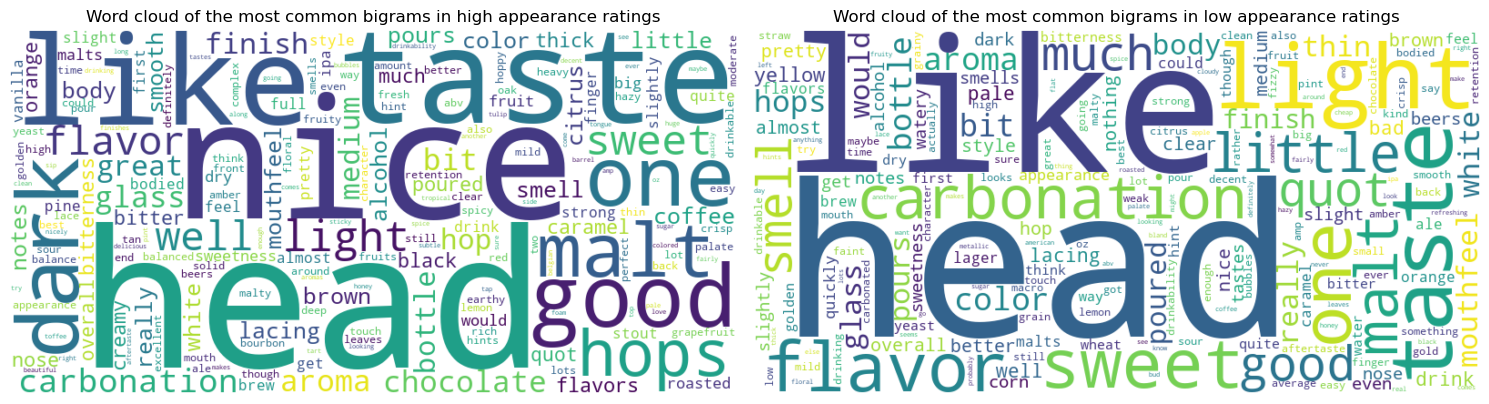

In [23]:
# Plot the word clouds
plt.figure(figsize=(15, 7))

# Word cloud for high appearance ratings
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_high, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud of the most common bigrams in high appearance ratings')

# Word cloud for low appearance ratings
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_low, interpolation='bilinear')
plt.axis('off')
plt.title('Word cloud of the most common bigrams in low appearance ratings')

plt.tight_layout()
plt.show()

In [24]:
# Get the top 20 most common bigrams in each group
top_bigrams_high = bigram_freq_high.most_common(20)
top_bigrams_low = bigram_freq_low.most_common(20)

# Create a function to calculate the percentage of reviews containing each bigram
def calculate_percentage_of_reviews_containing_bigram(bigrams, reviews):
    percentages = []
    for bigram, count in bigrams:
        # Check how many reviews contain this bigram
        num_reviews_containing_bigram = sum(
            1 for tokens in reviews['cleaned_tokens'] if tuple(bigram.split()) in zip(tokens[:-1], tokens[1:])
        )
        percentage = (num_reviews_containing_bigram / len(reviews)) * 100
        percentages.append((bigram, percentage))
    return percentages

# Calculate the percentage of reviews containing each bigram in both groups
percentages_high = calculate_percentage_of_reviews_containing_bigram(top_bigrams_high, reviews_high)
percentages_low = calculate_percentage_of_reviews_containing_bigram(top_bigrams_low, reviews_low)

# Create DataFrames for easier comparison
df_high = pd.DataFrame(percentages_high, columns=['Bigram', 'Percentage High Reviews'])
df_low = pd.DataFrame(percentages_low, columns=['Bigram', 'Percentage Low Reviews'])

# Merge the DataFrames for comparison
df_comparison = pd.merge(df_high, df_low, on='Bigram', how='outer')

# Print the comparison DataFrame
print(df_comparison)

            Bigram  Percentage High Reviews  Percentage Low Reviews
0       brown head                 3.905278                     NaN
1      brown sugar                 3.393749                     NaN
2        bud light                      NaN                2.478712
3       dark brown                 7.044670                2.736031
4   dark chocolate                 5.531608                     NaN
5       dark fruit                 3.817346                     NaN
6      dark fruits                 3.304657                     NaN
7      finger head                 3.907266                     NaN
8      full bodied                 5.320472                     NaN
9     golden color                      NaN                3.662129
10  head retention                      NaN                2.763379
11  hop bitterness                 3.979466                     NaN
12    light bodied                      NaN                4.918889
13      light body                      NaN     

### Review count analysis

In [25]:
# We extract the number of reviews for each beer
review_count = reviews_clean['beer_id'].value_counts()
reviews_clean['review_count'] = reviews_clean['beer_id'].map(review_count)

# We separate the reviews into two groups: those with a review count higher than 10000 and those with a review count lower than 10
reviews_high = reviews_clean[reviews_clean['review_count'] > 2000]
reviews_low = reviews_clean[reviews_clean['review_count'] < 10]

# Flatten the list of words from all reviews in each group
all_words_high = [
    word
    for tokens in tqdm(reviews_high['cleaned_tokens'], desc="Processing High Review Count")
    for word in tokens
    if word.isalpha() and word.lower() not in stopwords.words('english') and word.lower() != "beer"
]

all_words_low = [
    word
    for tokens in tqdm(reviews_low['cleaned_tokens'], desc="Processing Low Review Count")
    for word in tokens
    if word.isalpha() and word.lower() not in stopwords.words('english') and word.lower() != "beer"
]

# Count word frequencies for each group
word_freq_high = Counter(all_words_high)
word_freq_low = Counter(all_words_low)

# Generate the word clouds
wordcloud_high = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_high)
wordcloud_low = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_low)


/var/folders/kn/xrv1vh8j0k99dnh2mwl662xc0000gn/T/ipykernel_25020/3609125067.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_clean['review_count'] = reviews_clean['beer_id'].map(review_count)
Processing Low Review Count: 100%|██████████| 258530/258530 [18:04<00:00, 238.39it/s]


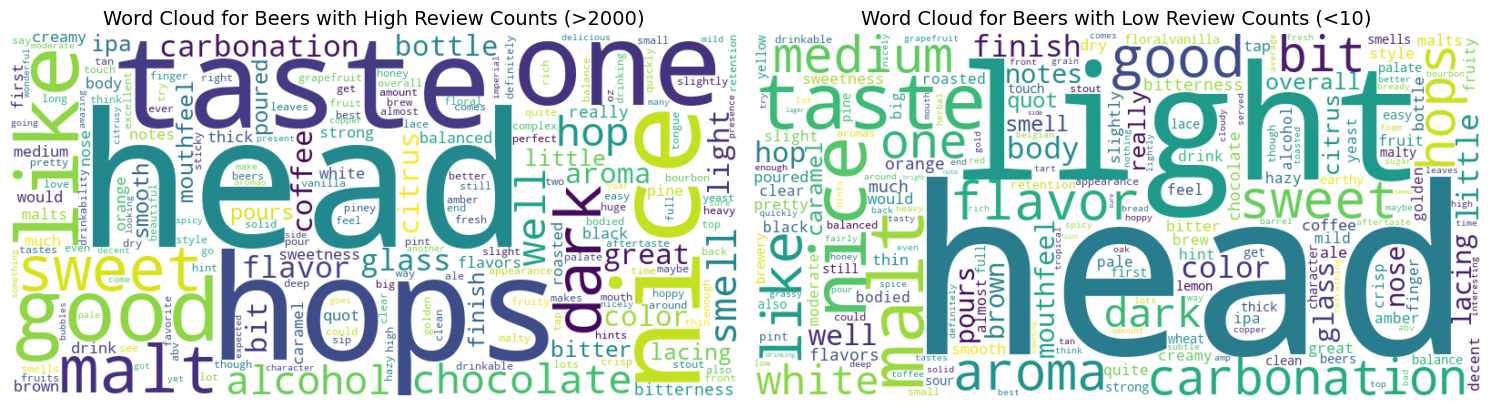

In [26]:
# Plot the word clouds
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_high, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Beers with High Review Counts (>2000)', fontsize=14)

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_low, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Beers with Low Review Counts (<10)', fontsize=14)

plt.tight_layout()
plt.show()